# Python Solution Notebook (Linear Regression for Bioinformatics)

This notebook:
- fits a multiple linear regression model using `sklearn`
- fits a multiple linear regression model using `statsmodels`
- prints coefficients + p-values + $R^2$ and adjusted $R^2$
- produces two diagnostic plots:
  1. Observed vs Predicted  
  2. Residuals vs Fitted


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as smf

In [2]:
# import data
in_file_name = '../data/data_for_MLR.csv'
df = pd.read_csv(in_file_name, index_col=0)
print(f'size of the data: {df.shape}\n')
print(df.head())

size of the data: (160, 6)

   log2_metabolite        age        bmi  smoking sex batch
0         8.396216  48.656605  22.174416        0   M     B
1         7.726311  32.520191  23.373870        0   M     A
2         9.119839  54.005414  37.642349        1   F     B
3         8.152221  56.286777  22.893067        0   M     B
4         8.134359  21.587578  31.192446        1   F     A


In [3]:
# Encode categorical variables
categorical_cols = ['smoking', 'sex', 'batch']
numerical_cols = ['age', 'bmi']

preprocess = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('numerical', 'passthrough', numerical_cols)
    ]
)

lr_model = Pipeline([
    ('preprocess', preprocess),
    ('regressor', LinearRegression())
])

#### Fit multiple linear regression using sklearn

In [4]:
# ---- Fit multiple linear regression using sklearn ----
X = df[['age', 'bmi', 'smoking', 'sex', 'batch']]
y = df[['log2_metabolite']]

lr_model.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('categorical', ...), ('numerical', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different

In [5]:
# display contents of the fitted model
preprocessing_obj = lr_model.named_steps['preprocess']
feature_names = preprocessing_obj.get_feature_names_out()
print(feature_names)
print()

transformed_X = preprocessing_obj.transform(X)
transformed_X_df = pd.DataFrame(
    transformed_X.toarray() if hasattr(transformed_X, 'toarray') else transformed_X,
    columns=feature_names
)
print(transformed_X_df.head())

['categorical__smoking_1' 'categorical__sex_M' 'categorical__batch_B'
 'categorical__batch_C' 'numerical__age' 'numerical__bmi']

   categorical__smoking_1  categorical__sex_M  categorical__batch_B  \
0                     0.0                 1.0                   1.0   
1                     0.0                 1.0                   0.0   
2                     1.0                 0.0                   1.0   
3                     0.0                 1.0                   1.0   
4                     1.0                 0.0                   0.0   

   categorical__batch_C  numerical__age  numerical__bmi  
0                   0.0       48.656605       22.174416  
1                   0.0       32.520191       23.373870  
2                   0.0       54.005414       37.642349  
3                   0.0       56.286777       22.893067  
4                   0.0       21.587578       31.192446  


In [6]:
# display results
print(f'coef: {lr_model.named_steps["regressor"].coef_}')
print(f'intercept: {lr_model.named_steps["regressor"].intercept_}')

coef: [[ 0.52971262 -0.11078118  0.28955504 -0.27962164  0.01650319  0.03827061]]
intercept: [6.13753552]


#### Fit multiple linear regression using statsmodels

In [7]:
# ---- Fit multiple linear regression using statsmodels ----
# C(sex) and C(batch) are treated as categorical (dummy-coded).
model = smf.ols("log2_metabolite ~ age + bmi + smoking + C(sex) + C(batch)", data=df).fit()

print(f"R^2: {model.rsquared:.4f}")
print(f"Adjusted R^2: {model.rsquared_adj:.4f}")

# Full summary (coefficients, SEs, t-stats, p-values, etc.)
print(model.summary())


R^2: 0.7218
Adjusted R^2: 0.7109
                            OLS Regression Results                            
Dep. Variable:        log2_metabolite   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     66.18
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           4.92e-40
Time:                        12:44:27   Log-Likelihood:                -3.0599
No. Observations:                 160   AIC:                             20.12
Df Residuals:                     153   BIC:                             41.65
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept    

In [8]:
# ---- Clean coefficient table ----
coef_table = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p_value": model.pvalues,
    "ci_low": model.conf_int()[0],
    "ci_high": model.conf_int()[1],
})
coef_table.index.name = "term"
coef_table.sort_values("p_value")


,coef,std_err,t,p_value,ci_low,ci_high
term,,,,,,
Intercept,6.137536,0.153607,39.956110,7.492766e-83,5.834071,6.441000
smoking,0.529713,0.049975,10.599609,4.992168e-20,0.430983,0.628442
bmi,0.038271,0.004084,9.370554,9.002633e-17,0.030202,0.046339
age,0.016503,0.001965,8.397214,2.888804e-14,0.012621,0.020386
C(batch)[T.B],0.289555,0.045382,6.380458,1.992351e-09,0.199900,0.379210
C(batch)[T.C],-0.279622,0.053510,-5.225600,5.600239e-07,-0.385335,-0.173908
C(sex)[T.M],-0.110781,0.040583,-2.729738,7.081979e-03,-0.190957,-0.030606


In [9]:
# ---- Predictions and residuals ----
df["predicted"] = model.fittedvalues
df["residual"] = model.resid
df[["log2_metabolite", "predicted", "residual"]].head()

,log2_metabolite,predicted,residual
0,8.396216,7.967927,0.428289
1,7.726311,7.457973,0.268338
2,9.119839,9.288660,-0.168821
3,8.152221,8.121352,0.030869
4,8.134359,8.217266,-0.082907


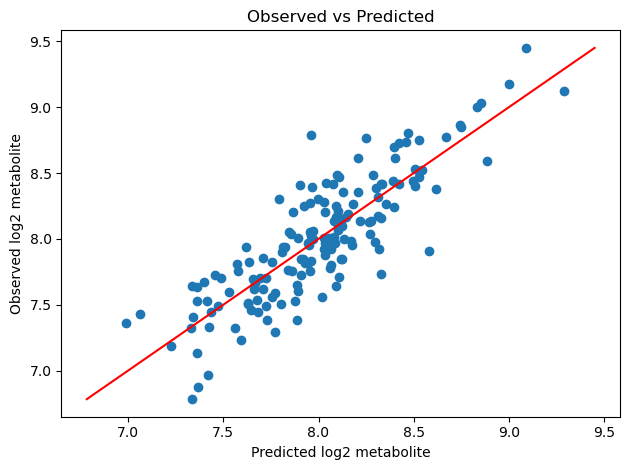

In [10]:
# ---- Plot 1: Observed vs Predicted ----
plt.figure()
plt.scatter(df["predicted"], df["log2_metabolite"])

minv = min(df["predicted"].min(), df["log2_metabolite"].min())
maxv = max(df["predicted"].max(), df["log2_metabolite"].max())
plt.plot([minv, maxv], [minv, maxv], color="red")

plt.xlabel("Predicted log2 metabolite")
plt.ylabel("Observed log2 metabolite")
plt.title("Observed vs Predicted")
plt.tight_layout()
plt.show()

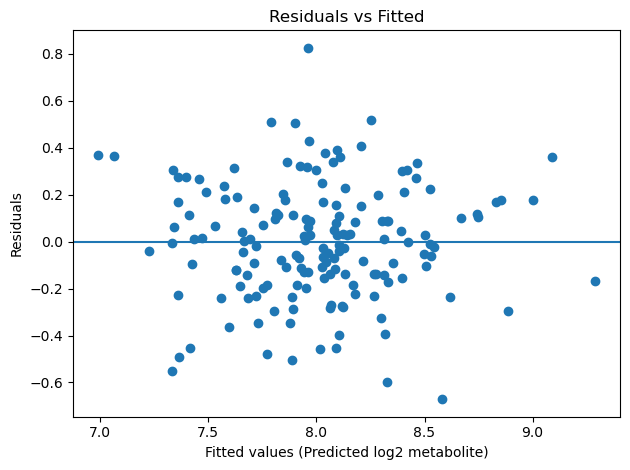

In [11]:
# ---- Plot 2: Residuals vs Fitted ----
plt.figure()
plt.scatter(df["predicted"], df["residual"])
plt.axhline(0)

plt.xlabel("Fitted values (Predicted log2 metabolite)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.tight_layout()
plt.show()

## Interpretation (example)

- **age** coefficient: expected change in log2 metabolite per 1-year increase in age, holding others constant  
- **bmi** coefficient: expected change per 1 BMI unit  
- **smoking** coefficient: difference between smokers (1) and non-smokers (0)  
- **C(sex)[T.M]**: difference between males and females (reference is `F`)  
- **C(batch)[T.B], C(batch)[T.C]**: differences vs reference batch `A`
